## Fitting DHO (Single-Band)
**Note:** 
- The CARMA autoregressive parameter index follows the covention of Kelly+14, which is different from the one used in Moreno+19.
- You need to import CARMA kernel from EzTaoX.kernels. The one from tinygp doesn't work (I will fix it later)

In [1]:
import warnings

import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import optax
from eztao.carma import CARMA_term, DHO_term, DRW_term
from eztao.ts import addNoise, gpSimFull, gpSimRand
from eztaox.fitter import fit
from eztaox.initializers import CARMAInit, DRWInit, UniformInit
from eztaox.kernels import CARMA
from eztaox.models import MultiVarModel, UniVarModel
from eztaox.utils import formatlc
from numpyro.infer import ESS, MCMC, NUTS, SA, BarkerMH
from eztaox.kernel_utils import carma_sf, carma_psd
from functools import partial

# from tinygp import kernels

warnings.filterwarnings(
    "ignore", category=RuntimeWarning
)  # Ignore ArviZ underflow warnings

jax.config.update("jax_enable_x64", True)

### 1. Simulate LC

Text(0, 0.5, 'Flux')

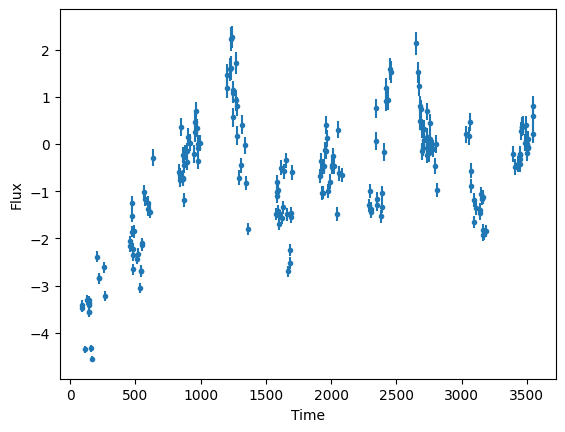

In [2]:
# note that here alpha parameter index are defined in this cell following the convention used in Moreno+19, which is the opposite to the one used in Kelly+14.
alphas = {"g": [0.06, 0.0001], "i": [0.06, 0.0001]}
betas = {"g": [0.005, 0.2], "i": [0.005, 0.2]}
snrs = {"g": 10, "i": 10}
sampling_seeds = {"g": 2, "i": 5}
noise_seeds = {"g": 111, "i": 2}

ts, ys, yerrs = {}, {}, {}
ys_noisy = {}
seed = 10
for band in "gi":
    DHO_kernel = DHO_term(*np.log(alphas[band]), *np.log(betas[band]))
    t, y, yerr = gpSimRand(
        DHO_kernel,
        snrs[band],
        365 * 10,
        200,
        full_N=100_000,
        lc_seed=seed,
    )

    # add to dict
    ts[band] = t
    ys[band] = y
    yerrs[band] = yerr
    ys_noisy[band] = addNoise(ys[band], yerrs[band], seed=noise_seeds[band] + seed)

for b in "g":
    plt.errorbar(ts[b][::1], ys_noisy[b][::1], yerrs[b][::1], fmt=".")
plt.xlabel('Time')
plt.ylabel('Flux')

### 2. Single Band Fit
#### 2.1 Best Fit

To fit DHO, you need to initiate a CARMA kernel by calling `CARMA.init`, which takes two arrays as arguments: alpha and beta. As noted above, the alpha parameter index should follow the convention used in Kelly+14.

In [3]:
# define params
zero_mean = False
has_jitter = True
p = 2
test_params = {"log_kernel_param": jnp.log(np.array([0.1, 1.1, 1.0, 3.0]))}

# define model
k = CARMA.init(
    jnp.exp(test_params["log_kernel_param"][:p]),
    jnp.exp(test_params["log_kernel_param"][p:]),
)
m = UniVarModel(
    ts["g"], ys_noisy["g"], yerrs["g"], k, zero_mean=zero_mean, has_jitter=has_jitter
)
m

UniVarModel(
  t=f64[200],
  y=f64[200],
  yerr=f64[200],
  inds=i64[200],
  kernel_def=<jax._src.util.HashablePartial object at 0xffff353e5250>,
  zero_mean=False,
  has_jitter=True
)

The `CARMAInit` function takes four input:
- CARMA p order
- CARMA q order
- alpha parameters
- beta parameter

In [4]:
# for CARMA kernel, the learning_rate needs to be larger
optimizer = optax.adam(learning_rate=1)

def initSampler2(key, nSample):
    # split keys
    subkeys = jax.random.split(key, 10)

    # uniform sampler
    meanSampler = UniformInit(1, [-0.3, 0.3])
    logJitterSampler = UniformInit(1, [-20, -5])

    # kernel init
    kernelSampler = CARMAInit(2, 1, [-16.0, 10.0], [-10.0, 2.0])

    return {
        "log_kernel_param": kernelSampler(subkeys[0], nSample),
        "mean": meanSampler(subkeys[2], nSample),
        "log_jitter": logJitterSampler(subkeys[4], nSample),
    }


initSample2 = initSampler2(jax.random.PRNGKey(10), 1)
initSample2

{'log_kernel_param': Array([-8.11211655e+00, -8.55370481e+00,  7.08350255e-04, -8.64258700e-01],      dtype=float64),
 'mean': Array(0.24264268, dtype=float64),
 'log_jitter': Array(-8.93528402, dtype=float64)}

In [5]:
prng_key = jax.random.PRNGKey(1)
nInitSample = 10_000
nIter = 3
nBest = 5
jaxoptMethod = "SLSQP"

bestP, logProb = fit(
    m, optimizer, initSampler2, prng_key, nInitSample, nIter, nBest, batch_size=1000
)
bestP, logProb

({'log_jitter': Array(-19.69875139, dtype=float64),
  'log_kernel_param': Array([-8.60288265, -2.68417456, -5.03176121, -1.56519081], dtype=float64),
  'mean': Array(-0.84648664, dtype=float64)},
 Array(-151.44103141, dtype=float64, weak_type=True))

#### 2.2 MCMC

In [6]:
params1 = bestP
prior_sigma = 2

def numpyro_model(t, yerr, y=None):
    # kernel param
    flat_normal = dist.Normal(
        params1["log_kernel_param"],
        jnp.array([prior_sigma, prior_sigma, prior_sigma, prior_sigma]),
    )
    diag_normal = dist.Independent(flat_normal, 1)
    log_kernel_param = numpyro.sample("log_kernel_param", diag_normal)

    # log jitter
    log_jitter = numpyro.sample("log_jitter", dist.Normal(params1["log_jitter"], 2.0))
    mean = numpyro.sample("mean", dist.Normal(0.0, 0.1))

    # kernel
    k = CARMA.init(jnp.exp(log_kernel_param)[:p], jnp.exp(log_kernel_param)[p:])

    m = UniVarModel(
        t,
        y,
        yerr,
        k,
        zero_mean=zero_mean,
        has_jitter=has_jitter,
    )

    sample_params = {
        "log_kernel_param": log_kernel_param,
        "log_jitter": log_jitter,
        "mean": mean,
    }
    m.sample(sample_params)

In [7]:
%%time
nuts_kernel = NUTS(
    numpyro_model,
    dense_mass=True,
    target_accept_prob=0.9,
    # adapt_step_size=True,
)

mcmc = MCMC(
    nuts_kernel,
    num_warmup=500,
    num_samples=1000,
    num_chains=1,
    progress_bar=True,
    # chain_method="vectorized",
)

seed = 10
test_band = "g"
mcmc.run(
    jax.random.PRNGKey(seed),
    jnp.asarray(ts[test_band]),
    jnp.asarray(yerrs[test_band]),
    y=jnp.asarray(ys_noisy[test_band]),
)
data = az.from_numpyro(mcmc)
mcmc.print_summary()

sample: 100%|██████████| 1500/1500 [00:02<00:00, 546.87it/s, 7 steps of size 4.39e-01. acc. prob=0.94]  



                         mean       std    median      5.0%     95.0%     n_eff     r_hat
         log_jitter    -19.66      2.01    -19.67    -23.30    -16.57    992.75      1.00
log_kernel_param[0]     -9.59      1.14     -9.53    -11.44     -7.88    737.83      1.00
log_kernel_param[1]     -2.81      0.54     -2.78     -3.72     -1.95    970.50      1.00
log_kernel_param[2]     -5.23      0.70     -5.17     -6.30     -4.11    805.01      1.00
log_kernel_param[3]     -1.57      0.09     -1.57     -1.71     -1.42   1086.04      1.00
               mean     -0.01      0.10     -0.01     -0.18      0.15    757.08      1.00

Number of divergences: 0
CPU times: user 5.53 s, sys: 303 ms, total: 5.83 s
Wall time: 5.76 s


array([[<Axes: title={'center': 'log_kernel_param'}>,
        <Axes: title={'center': 'log_kernel_param'}>],
       [<Axes: title={'center': 'mean'}>,
        <Axes: title={'center': 'mean'}>]], dtype=object)

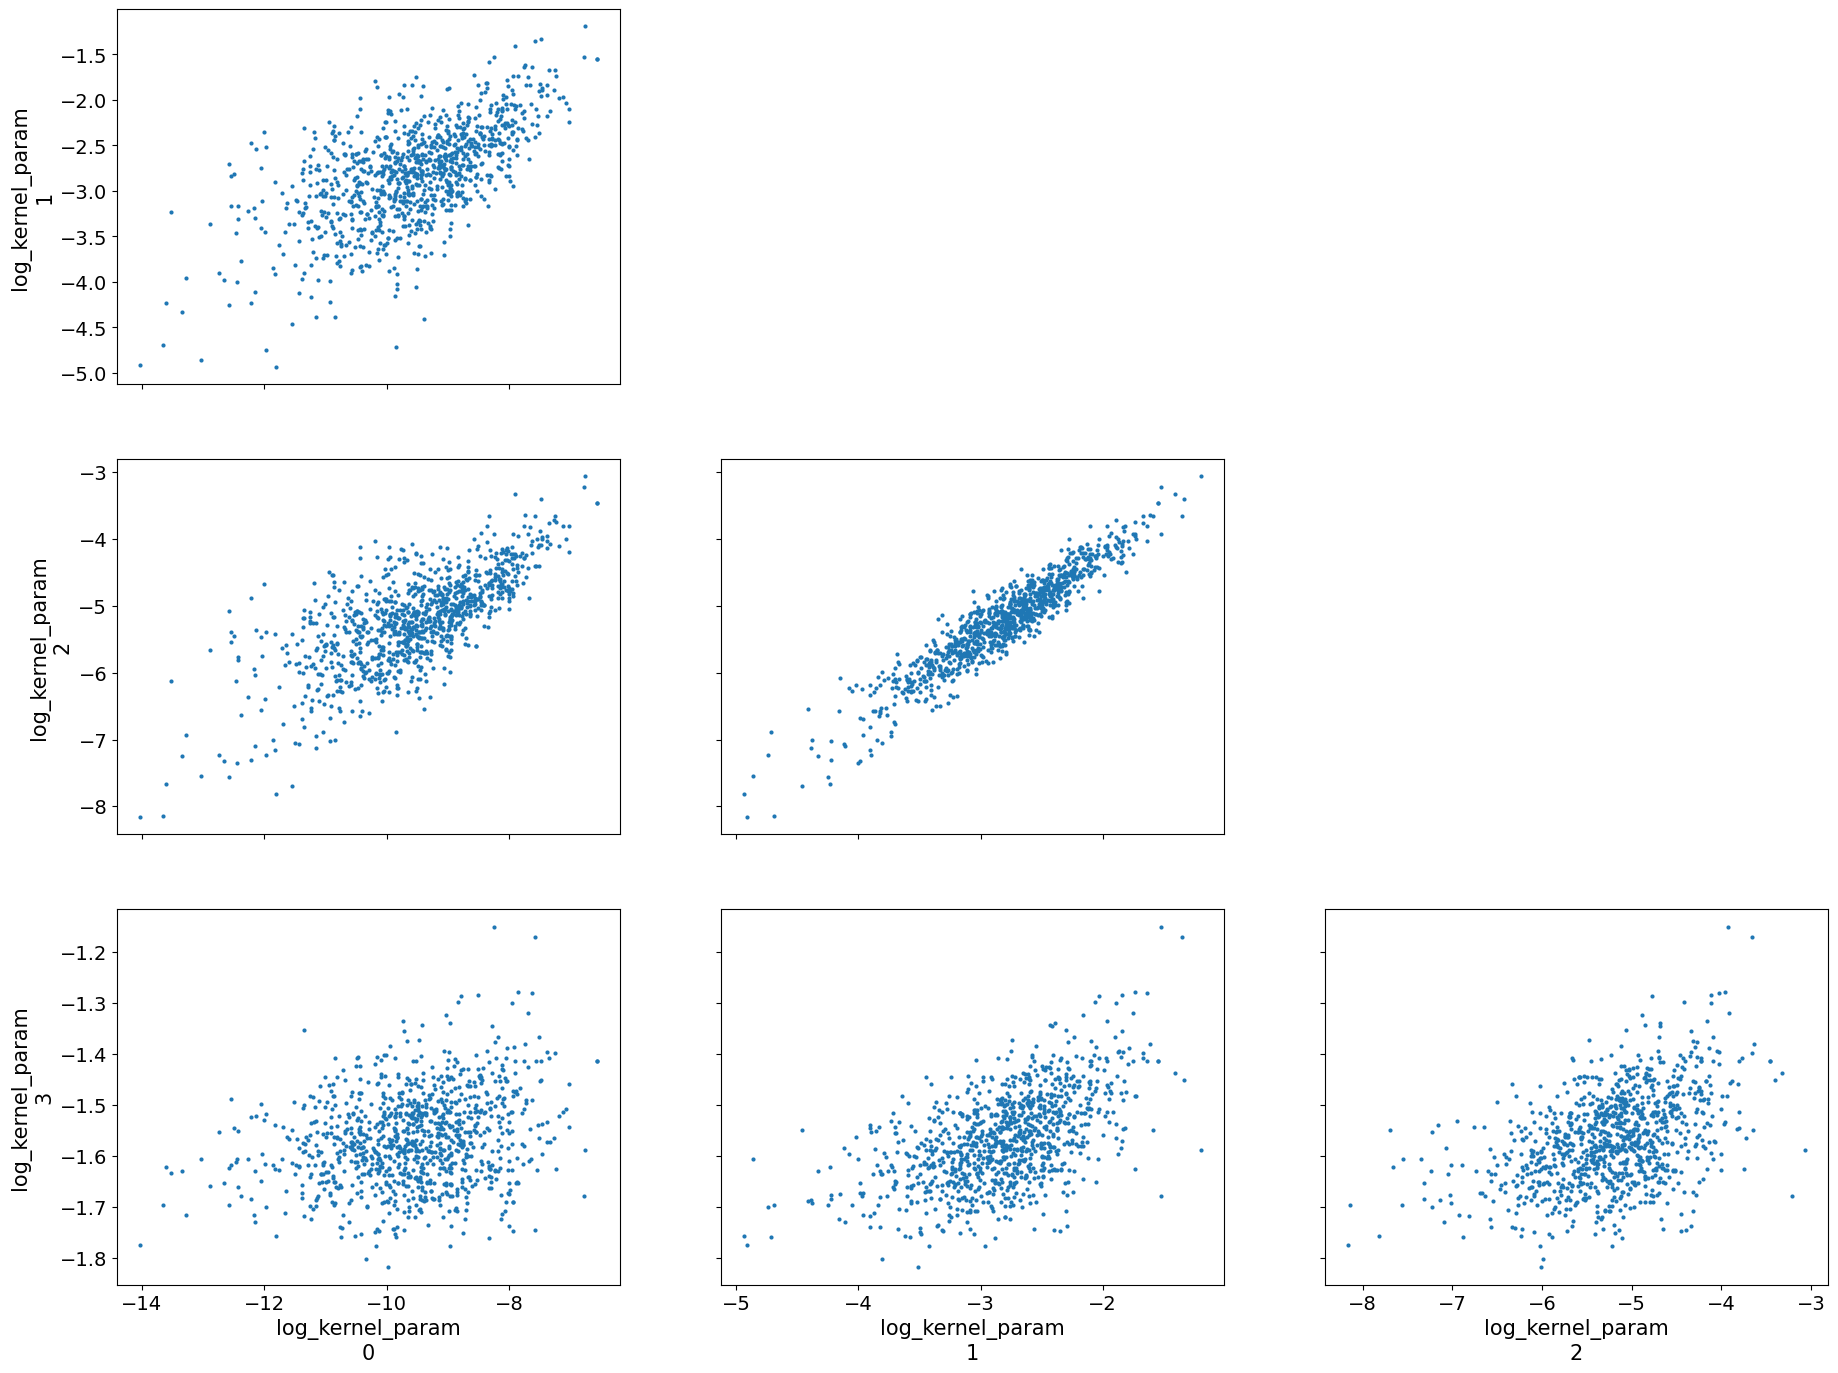

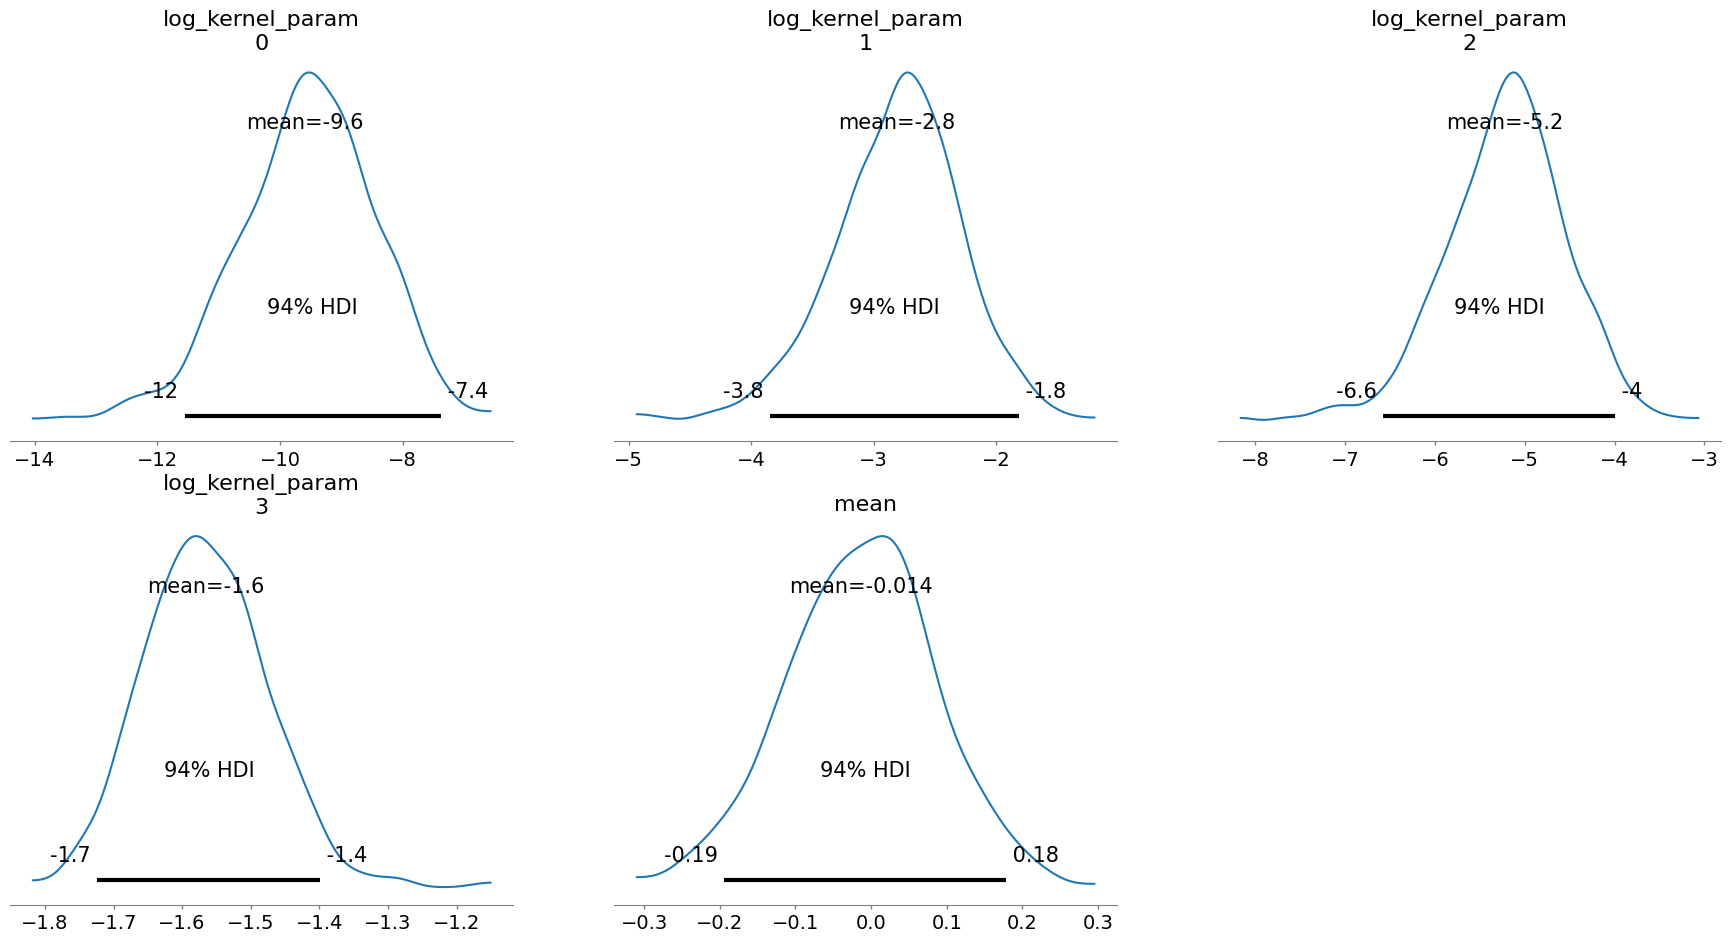

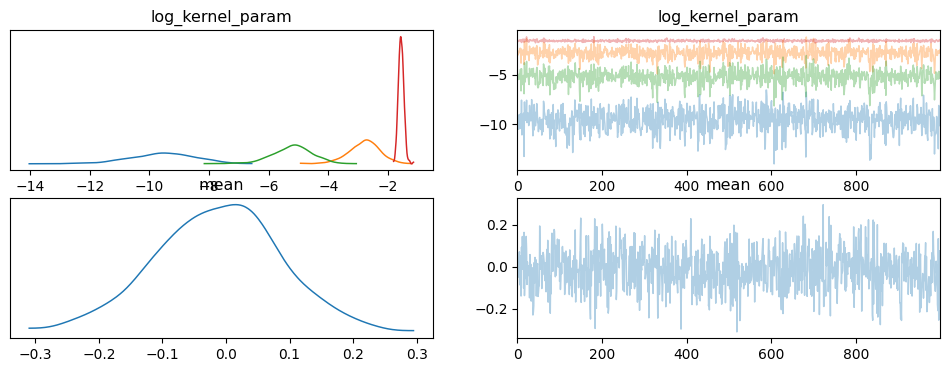

In [8]:
az.plot_pair(data, var_names=["log_kernel_param"])
az.plot_posterior(data, var_names=["log_kernel_param", "mean"])
az.plot_trace(data, var_names=["log_kernel_param", "mean"])

### 3. Visualize LC

In [9]:
sim_t = jnp.linspace(0, 3650, 1000)
sim_y, sim_yerr = m.pred(bestP, sim_t)

Text(0, 0.5, 'flux')

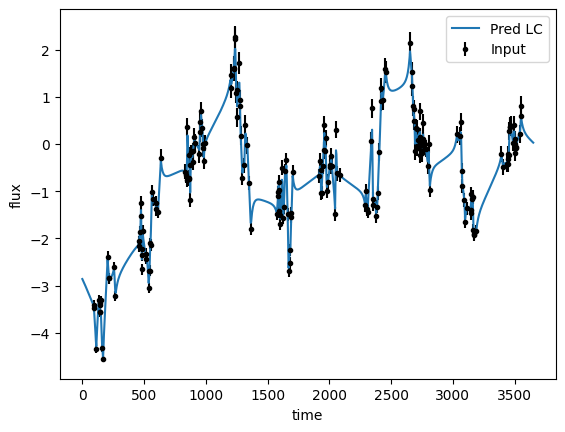

In [10]:
plt.errorbar(ts["g"], ys_noisy["g"], yerrs["g"], fmt="k.", label='Input')
plt.plot(sim_t, sim_y, label='Pred LC')
plt.legend()
plt.xlabel('time')
plt.ylabel('flux')

### 4. Visualize PSD/SF

In [11]:
from eztao.carma import carma_psd as eztao_carma_psd
from eztao.carma import carma_sf as eztao_carma_sf

#### 4.1 PSD

In [12]:
# get mcmc sample
samples = mcmc.get_samples()

f = jnp.logspace(-4, -1)
# best fit PSD

best_dho_param = jnp.exp(bestP['log_kernel_param'])
best_psd = carma_psd(f, best_dho_param[:p], best_dho_param[p:])

# MCMC psd; warning: high memory usage
mcmc_dho_params = jnp.exp(samples['log_kernel_param']).T
mcmc_dho_params = mcmc_dho_params[:, ::5] # select a sub_sample
mcmc_psds = jax.vmap(partial(carma_psd, f))(mcmc_dho_params[:p].T, mcmc_dho_params[p:].T)

mcmc_psd_gmean = 10**(jnp.log10(mcmc_psds).mean(axis=0))
mcmc_psd_p16 = jnp.percentile(mcmc_psds, 16, axis=0)
mcmc_psd_p84 = jnp.percentile(mcmc_psds, 84, axis=0)

# true psd
true_psd = eztao_carma_psd(alphas['g'], betas['g'])

Text(0, 0.5, 'PSD')

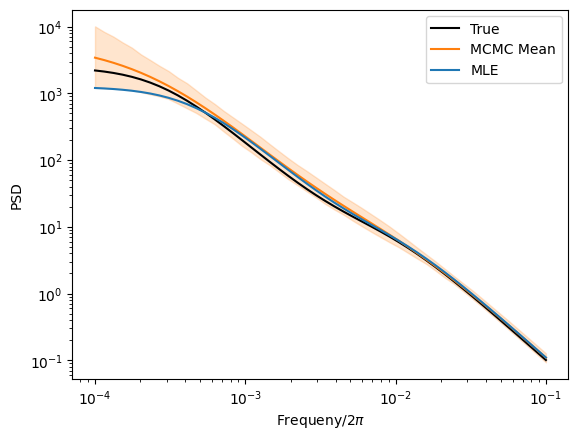

In [13]:
plt.loglog(f, true_psd(f), label='True', color='k')
plt.loglog(f, mcmc_psd_gmean, label='MCMC Mean', color='tab:orange')
plt.fill_between(f, mcmc_psd_p16, mcmc_psd_p84, color='tab:orange', alpha=0.2)
plt.loglog(f, best_psd, label='MLE')
plt.legend()
plt.xlabel(r'Frequeny/$2\pi$')
plt.ylabel('PSD')

#### 4.2 SF

In [14]:
# get mcmc sample
# samples = mcmc.get_samples()

t = np.logspace(-1, 4)
# best fit PSD

best_sf = carma_sf(t, best_dho_param[:p], best_dho_param[p:])

# MCMC psd; warning: high memory usage
mcmc_sfs = jax.vmap(partial(carma_sf, t))(mcmc_dho_params[:p].T, mcmc_dho_params[p:].T)
mcmc_sf_gmean = 10**(jnp.log10(mcmc_sfs).mean(axis=0))
mcmc_sf_p16 = jnp.percentile(mcmc_sfs, 16, axis=0)
mcmc_sf_p84 = jnp.percentile(mcmc_sfs, 84, axis=0)

# true sf
true_sf = eztao_carma_sf(np.array(alphas['g']), np.array(betas['g']))

Text(0, 0.5, 'SF')

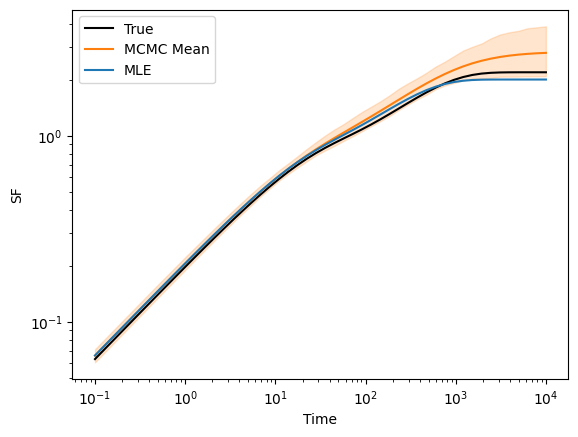

In [16]:
plt.loglog(t, true_sf(t), label='True', color='k')
plt.loglog(t, mcmc_sf_gmean, label='MCMC Mean', color='tab:orange')
plt.fill_between(t, mcmc_sf_p16, mcmc_sf_p84, color='tab:orange', alpha=0.2)
plt.loglog(t, best_sf, label='MLE')
plt.legend()
plt.xlabel(r'Time')
plt.ylabel('SF')